<a href="https://colab.research.google.com/github/WagnerPrata/Minera-o-de-dados-no-Twitter-/blob/main/V5_Analise_de_Sentimentos_Tweets_COVID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalações das Bibliotecas**

In [ ]:
pip install tweepy textblob matplotlib wordcloud googletrans unidecode -q

     |████████████████████████████████| 235 kB 5.2 MB/s 
     |████████████████████████████████| 55 kB 3.4 MB/s 
     |████████████████████████████████| 42 kB 1.3 MB/s 
     |████████████████████████████████| 1.4 MB 59.0 MB/s 
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 65 kB 3.7 MB/s 


In [ ]:
pip install TwitterSearch -q

In [ ]:
pip install --upgrade textblob -q

     |████████████████████████████████| 636 kB 5.0 MB/s 


In [ ]:
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import tweepy
import json
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from googletrans import Translator
from unidecode import unidecode
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
consumer_key = "t8Q09x93v407DU5A2IpwZ97VV" 
consumer_secret = "mBu1akvfgV6C3HsXxHars4CCFj7YmJYAHTRYLffP3S5eTxeIQ1"
access_token = "1448303543056805890-DZclAOTLpj1Bv721uGuu8SniSws8Ya"
access_token_secret = "yaHeNWhHzMHVgNMfxMVd3cgZgG1tsx9ArmjWHYrxGscf5"

In [ ]:
#Criando nossa autenticação
auth = tweepy.OAuthHandler(consumer_key,consumer_secret)
#"Direcionando" o token de acesso
auth.set_access_token(access_token, access_token_secret) 
#criando o objeto da API usando nossas credenciais
api = tweepy.API(auth, wait_on_rate_limit = True)

In [ ]:
language = 'pt'

# **Extração de dados Twiiter** 

In [ ]:
from TwitterSearch import *

#CHAVES DE ACESSO TWITTER
try:
    ts = TwitterSearch(
        consumer_key = consumer_key ,
        consumer_secret = consumer_secret,
        access_token = access_token,
        access_token_secret = access_token_secret
    )
    
    #ATRIBUTOS DA PESQUISA
   
    tso = TwitterSearchOrder()
    #tso.set_geocode(-11.0058313,-37.1731961,25, imperial_metric=False)
    tso.set_keywords(['since:2022-10-15','2022-10-08'])         
    tso.set_keywords(['UniversidadeEuDefendo','CienciaEuDefendo','EducacaoEuDefendo'], or_operator = True) #Aqui serão as palavras chaves tso.set_keywords(['vacina','vírus', 'coronavírus'], or_operator = True) #Aqui serão as palavras chaves 
    tso.set_language('pt') 
    cont = 1 #condicao de parada, quantidade de resultados

    for tweet in ts.search_tweets_iterable(tso):
        print('created_at: ',tweet['created_at'], 'User_id: ',tweet['id_str'], 'Tweet: ',tweet['text'] ) 
        created_at = tweet['created_at']
        user_id = tweet['id_str']
        texto = tweet['text']
        
        cont += 1
        if cont>10000: #condicao de parada, quantidade de resultados
            break

        with open("dado.json", "a+") as output:

          data = {"created_at": created_at,
                  "User_id": user_id,
                  "Tweets": texto}
          output.write("{}\n".format(json.dumps(data)))

except TwitterSearchException as e:
  print(e)

created_at:  Sun Oct 16 00:57:14 +0000 2022 User_id:  1581449151820095489 Tweet:  RT @UFPA_Oficial: Hoje, dia das(os) professoras(es), também é dia de celebrar e de defender a ciência, a educação e as universidades públic…
created_at:  Sun Oct 16 00:54:14 +0000 2022 User_id:  1581448395444539393 Tweet:  RT @Andifes: É incrível o que acontece nas universidades! E tem muito mais por todo o país. Nos conte o que acontece por aí e como a educaç…
created_at:  Sun Oct 16 00:53:18 +0000 2022 User_id:  1581448162446745600 Tweet:  RT @UFPR: Todos juntos no twittaço da Educação! 
Em defesa da Universidade pública, gratuita e de qualidade!
#universidadeeudefendo
#educac…
created_at:  Sun Oct 16 00:45:41 +0000 2022 User_id:  1581446244404035584 Tweet:  RT @uneoficial: No dia dos professores a mensagem que fica é de resistência. Precisamos defender a educação!!

#Universidadeeudefendo
#educ…
created_at:  Sun Oct 16 00:43:17 +0000 2022 User_id:  1581445642102009858 Tweet:  #EducaçãoEuDefendo
Defendo

In [ ]:
import pandas as pd
df = pd.read_json('dado.json', lines = True)
#df.head(10) #mostrando 10 resultados

In [ ]:
df.head()

NameError: ignored

In [ ]:
#Duplica a base da dados para CSV
df.to_csv ("dado.csv")
#df.head(10) #mostrando 10 resultados

In [ ]:
dados = pd.read_csv('/content/dado.csv') #lendo a base de dados duplicada
#dados.head()

# **Limpeza de Dados**

In [ ]:
dados = pd.DataFrame(dados, columns = ['Tweets'])

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
def limpando_chars(text):
    text = re.sub('@[A-Za-z0–9]+', '', text) #removendo @
    text = re.sub('#', '', text) #removendo #
    text = re.sub('RT[\s]+', '', text) # Removendo RT
    text = re.sub('https?:\/\/\S+', '', text) # Removendo hyperlink
    text = re.sub('&amp','', text)# removendo marcação HTML de início
    text = re.sub(r"[^a-zA-Zà-úÀ-Ú0-9]", " ", text.lower()) # Converte para minúsculo
    return text

In [ ]:
#limpando os tweets com a função criada
dados['Tweets'] = dados['Tweets'].apply(limpando_chars)

In [ ]:
dados

,Tweets
0,educaçãoeudefendo defendo o ensino público de ...
1,a ufrn está mais uma vez entre as melhor...
2,lutamos em defesa da educação pública gratu...
3,aliel educacaoeudefendo 15 10 dia dos p...
4,38829518 em defesa da universidade pública g...
...,...
2014,após ampla mobilização o mec anunciou q dev...
2015,após ampla mobilização o mec anunciou q dev...
2016,após ampla mobilização o mec anunciou q dev...
2017,após ampla mobilização o mec anunciou q deve ...


In [ ]:
#Copiando o dataframe(com dados limpos) para usar no nuvem de palvras
Word_Cloud = pd.DataFrame(dados, columns = ['Tweets'])
dados = Word_Cloud
Word_Cloud.to_csv ("Nuvem.csv")

# **Preparando para análise - Tradução** 

In [ ]:
!pip install translate -q

In [ ]:
from translate import Translator
from textblob import TextBlob
import translate

In [ ]:
for index, row in dados.iterrows():
    pt_blob = dados.iloc[index]['Tweets']
    translator = Translator(from_lang="pt", to_lang="en")
    #translator = Translator(to_lang="en") #Traduzir para Inglês    pt_blob = translator.translate(pt_blob)
    en_blob = translator.translate(pt_blob)
    dados.at[index, str('Tweets')] = str(en_blob)
dados.head(100)

KeyboardInterrupt: ignored

In [ ]:
#trandformo o dataframe em um arquivo CSV - para aplicar a analise 
dados.to_csv("traducao.csv")


In [ ]:
#Cria um dataframe especifico para analise 
analise = pd.read_csv("traducao.csv")

# **Análise de Twiiter Negativos de Positivos**

In [ ]:
from sklearn.metrics import accuracy_score #acuracia

In [ ]:
# Função que analisa e obtém a subjetividade
def capture_subjetividade_pt(text):
    return TextBlob(text).sentiment.subjectivity
# Função que analisa e obtém a polaridade
def capture_polaridade_pt(text):
    return  TextBlob(text).sentiment.polarity

#def translate_text(text): #Aqui encontramos limitações na quantidade de traduções 
      #translator = Translator(from_lang="pt", to_lang="en") #Traduzir de Portugues para Ingles
      #return translator.translate(text)

#Traduzindo
#df_tweets['Tweets'] = df_tweets['Tweets'].apply(translate_text)

# Criar duas colunas de subjetividade e polaridade

analise['Subjetividade'] = analise['Tweets'].apply(capture_polaridade_pt)
analise['Polaridade'] = analise['Tweets'].apply(capture_subjetividade_pt)

# Mostra um novo dataframe com as colunas subjetividade e polaridade
#analise.tail(25)

In [ ]:
# Mostra um novo dataframe com as colunas subjetividade e polaridade
analise.tail(100)

,Unnamed: 0,Tweets,Subjetividade,Polaridade
18,18,1 eleger lula e por fascistas safados como voc...,0.0,0.0
19,19,valdemar costa neto roberto jeferson arth...,0.0,0.0
20,20,19674215 mulher apoiando bolsonaro negro ap...,0.0,0.0
21,21,votar no bolsonaro para ele me dá uma arma e e...,0.0,0.0
22,22,eu quero que fábio declare apoio a bolsonaro ...,0.0,0.0
...,...,...,...,...
113,113,quem tiver uma gota de sangue nordestino não ...,0.0,0.0
114,114,r nesse caso não porque o voto dele no prime...,0.0,0.0
115,115,meu irmão reclamando com minha mãe sobre minha...,0.0,0.0
116,116,4 bolsonaro diz que não houve atraso na vacin...,0.0,0.0


In [ ]:
#-1 negativo
#0 neutro
#1 positivo
def gerar_analise(score):
    if score < 0:
        return 'Negativo'
    elif score == 0:
        return 'Negativo'
    else:
        return 'Positivo'
analise['Analise'] = analise['Polaridade'].apply(gerar_analise)

In [ ]:
analise.to_csv("Analise.csv") #Criando um arquivo CSV das Analise 

In [ ]:
analise

,Unnamed: 0,Tweets,Subjetividade,Polaridade,Analise
0,0,47745890dbora olhe a diferença de 2018 pra 2...,0.0,0.0,Negativo
1,1,47745890dbora não creio que seja isso depoi...,0.0,0.0,Negativo
2,2,mafs você tá falando com um eleitor do ciro...,0.0,0.0,Negativo
3,3,inforzato godoy mostra ae o q o bozo fez ...,0.0,0.0,Negativo
4,4,link da reportagem,0.0,0.0,Negativo
...,...,...,...,...,...
113,113,quem tiver uma gota de sangue nordestino não ...,0.0,0.0,Negativo
114,114,r nesse caso não porque o voto dele no prime...,0.0,0.0,Negativo
115,115,meu irmão reclamando com minha mãe sobre minha...,0.0,0.0,Negativo
116,116,4 bolsonaro diz que não houve atraso na vacin...,0.0,0.0,Negativo


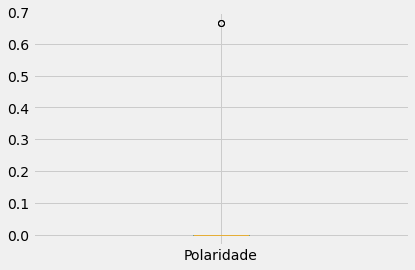

In [ ]:
from seaborn.categorical import boxplot
import matplotlib.pyplot as plt
analise.boxplot(column= ['Polaridade'])
plt.savefig('Boxplot_Polaridade.png', format='png')
plt.show()

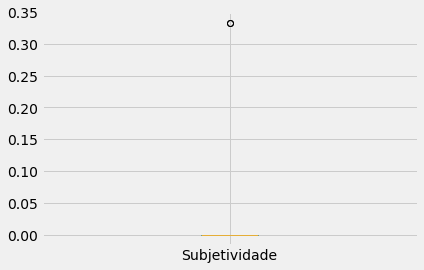

In [ ]:
import matplotlib.pyplot as plt
analise.boxplot(column= ['Subjetividade'])
plt.savefig('Boxplot_Subjetividade.png', format='png')
plt.show()

In [ ]:
# Printando apenas os tweets positivos 
print('Tweets Positivos:\n')
j=1
sortedDF = analise.sort_values(by=['Polaridade']) #ordenando os tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analise'][i] == 'Positivo'):
        print(str(j) + ') '+ sortedDF['Tweets'][i])
        print()
        j= j+1

Tweets Positivos:

1) chegou uma querida super simpática aqui no escritório e eu logo notei que o papel de parede do relógio dela era a e  

2) chegou uma querida super simpática aqui no escritório e eu logo notei que o papel de parede do relógio dela era a e  



In [ ]:
# Printando apenas os tweets negativos 
print('Tweets Negativos:\n')
j=1
sortedDF = analise.sort_values(by=['Polaridade'],ascending=False) #ordenando os tweets
for i in range(0, sortedDF.shape[0] ):
    if( sortedDF['Analise'][i] == 'Negativo'):
        print(str(j) + ') '+sortedDF['Tweets'][i])
        print()
        j=j+1

Tweets Negativos:

1)  47745890dbora  olhe a diferença de 2018 pra 2022  se o candidato n fosse o lula já  

2)  47745890dbora  não creio que seja isso  depois que o lula morrer o nordeste se divide de novo

3)  mafs   você tá falando com um eleitor do ciro que foi no lula já no primeiro turno pelo  

4)  inforzato   godoy mostra ae o q o bozo fez   receba mais um pouquinho de lula presidente    

5)  link da reportagem   

6)   sobre os votos do ciro e tebet acho essa aí coerente  já vi do poder data que 94  da te  

7) eu também perdi  fora bolsonaro  

8)  sem falar que se entrar no mérito de ditadores que apoiam lula  também há ultradireitista com viés dita  

9) 71 1 claro q é lula 

10)  inforzato   godoy o ratinho cabo eleitoral do bozo entrevistou o lula  vai lá assiste e aprenda um pouco   

11) deixem o lula falar kkkkkkkkk 

12) cada voto no lula 13 é um murro na cara do bozonazi    

13)  moro cadelinha do bolsonaro

14)   que prepotência    complicado essa militância   min

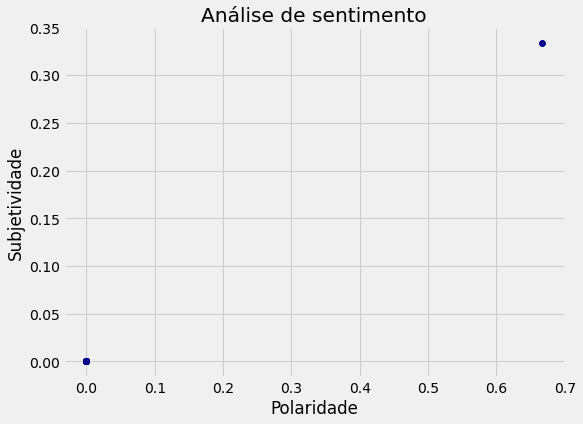

In [ ]:
# Plotting 
plt.figure(figsize=(8,6)) 
for i in range(0, analise.shape[0]):
    plt.scatter(analise["Polaridade"][i], analise["Subjetividade"][i], color='darkblue') 
plt.title('Análise de sentimento') 
plt.xlabel('Polaridade') 
plt.ylabel('Subjetividade')
plt.savefig('Gráfico de dispersão.png', format='png')
plt.show()

In [ ]:
#Percentual de Tweets positivos
ptweets = analise[analise.Analise == 'Positivo']
ptweets = ptweets['Tweets']
ptweets

round( (ptweets.shape[0] / analise.shape[0]) * 100 , 1)

1.7

In [ ]:
#Percentual de Tweets Negativo
ntweets = analise[analise.Analise == 'Negativo']
ntweets = ntweets['Tweets']
ntweets

round( (ntweets.shape[0] / analise.shape[0]) * 100, 1)

98.3

In [ ]:
df = pd.DataFrame(analise['Analise'].value_counts())

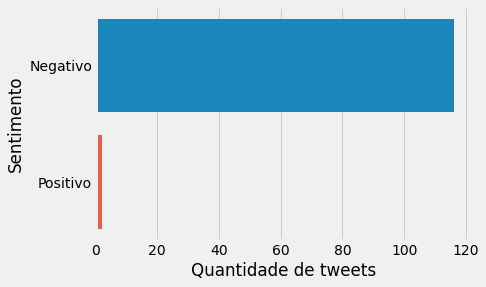

In [ ]:
plt.figure()
ax = sns.barplot(x=df['Analise'], y=df.index, data=analise)
ax.set_xlabel('Quantidade de tweets')
ax.set_ylabel('Sentimento');

plt.savefig('Barra01.png', format='png')
plt.show()

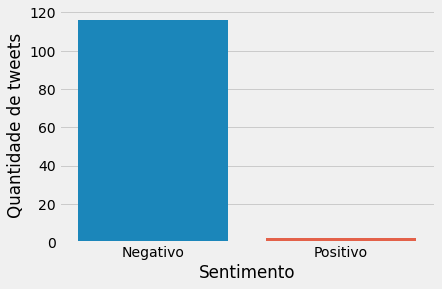

In [ ]:
ax = sns.barplot(x=df.index, y=df['Analise'],data=analise,label='Quantidade de Tweets')
ax.set_ylabel('Quantidade de tweets')
ax.set_xlabel('Sentimento');
plt.savefig('Gráfico Barra 02.png', format='png')
plt.show()

# **Nuvem de palavras**

In [ ]:
!pip install wordcloud -q

In [ ]:
df = pd.read_csv("/content/Nuvem.csv") #lendo a base de dados duplicada

In [ ]:
# concatenar as frases
all_frases = " ".join(s for s in df['Tweets'])
print("Quantidade de Palavras: {}".format(len(all_frases)))

Quantidade de Palavras: 9417


In [ ]:
#Palavras indesejaveis e sem sentido
stopwords = set(STOPWORDS)
stopwords.update(['eu','ver','principal','essa','isso','vez','nas','mas','qual','principal','ele','ter','doença','pois','este','vez','ver principal','artigo principal','já','aos','pode','outro','artigo','desse','alguns','meio','entre','das','podem','esse','seu','também','são','quando','de', 'que','em','os','as','da','como','dos','ou','se','um','uma','para','na','ao','mais','por','não','ainda','muito','sua'] + list(STOPWORDS) )

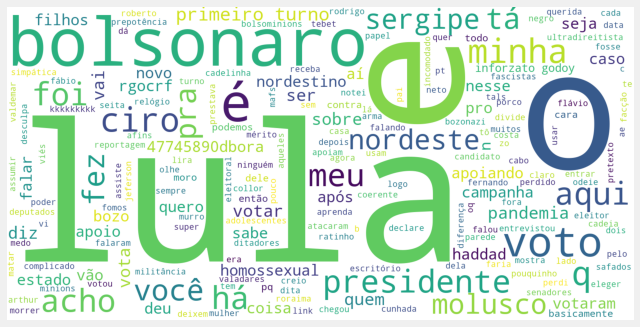

In [ ]:
# configurando a wordcloud
wordcloud = WordCloud(stopwords=stopwords,
                      background_color="white",
                      width=1600, height=800).generate(all_frases)


fig, ax = plt.subplots(figsize=(10,6))
ax.imshow(wordcloud, interpolation='bilinear')
ax.set_axis_off()

# mostrar a imagem
plt.imshow(wordcloud);

# salvar a imagem no diretório
wordcloud.to_file("wordcloud.png")

#**Tokeniza**

In [ ]:
#import Countvectorizar para cantar numero de vezes que uma palavra ocorre
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
#Crie uma matriz para mostrar o número de vezes que palavras específicas aparecem no texto da coluna
cv = CountVectorizer()
count_matriz = cv.fit_transform(df.Tweets)

In [ ]:
word_count = pd.DataFrame(cv.get_feature_names(), columns=['word'])
word_count["count"] = count_matriz.sum(axis = 0).tolist()[0]
word_count = word_count.sort_values("count", ascending = False).reset_index(drop =True)
word_count[:100]


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,word,count
0,que,61
1,lula,60
2,bolsonaro,44
3,de,41
4,no,32
...,...,...
95,saúde,2
96,sangue,2
97,minhas,2
98,safados,2


# **Futuras melhorias**

In [ ]:
def RemoveStopWords(instancia):
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [i for i in instancia.split() if not i in stopwords]
    return (" ".join(palavras))

In [ ]:
def Stemming(instancia):
    stemmer = nltk.stem.RSLPStemmer()
    palavras = []
    for w in instancia.split():
        palavras.append(stemmer.stem(w))
    return (" ".join(palavras))

In [ ]:
def Limpeza_dados(instancia):
    # remove links, pontos, virgulas,ponto e virgulas dos tweets
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    return (instancia)

In [ ]:
def Preprocessing(text):
    stemmer = nltk.stem.RSLPStemmer()
    instancia = re.sub(r"http\S+", "", instancia).lower().replace('.','').replace(';','').replace('-','').replace(':','').replace(')','')
    stopwords = set(nltk.corpus.stopwords.words('portuguese'))
    palavras = [stemmer.stem(i) for i in instancia.split() if not i in stopwords]
    return text


In [ ]:
from bs4 import BeautifulSoup

def tweet_to_words(tweet):
    
    text = BeautifulSoup(tweet, "html.parser").get_text() # Remove HTML tags
    text = re.sub(r"[^a-zA-Zà-úÀ-Ú0-9]", " ", text.lower()) # Converte para minúsculo
    words = tweet_tokenizer.tokenize(text)
    
    return words